<a href="https://colab.research.google.com/github/erwanmaulana/Tugas-ML/blob/main/Minggu9_4_4_Model_Selection%2C_Underfitting%2C_and_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install d2l==0.17.0

In [70]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [71]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [72]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-0.4020492],
        [ 1.6171364]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.00000000e+00, -4.02049214e-01,  8.08217824e-02,
         -1.08314445e-02,  1.08869339e-03, -8.75416590e-05,
          5.86600936e-06, -3.36917765e-07,  1.69321890e-08,
         -7.56397056e-10,  3.04108821e-11, -1.11151561e-12,
          3.72403287e-14, -1.15172647e-15,  3.30750517e-17,
         -8.86519861e-19,  2.22765394e-20, -5.26839077e-22,
          1.17675131e-23, -2.49006287e-25],
        [ 1.00000000e+00,  1.61713636e+00,  1.30756497e+00,
          7.04836965e-01,  2.84954369e-01,  9.21620056e-02,
          2.48397551e-02,  5.73846744e-03,  1.15998555e-03,
          2.08428304e-04,  3.37056990e-05,  4.95515542e-06,
          6.67763459e-07,  8.30665101e-08,  9.59499058e-09,
          1.03442721e-09,  1.04550611e-10,  9.94544638e-12,
          8.93507924e-13,  7.60486373e-14]], dtype=float32)>,
 <tf.Tensor: 

In [73]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [74]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

weight: [[ 4.982563   1.2482378 -3.4127014  5.417616 ]]


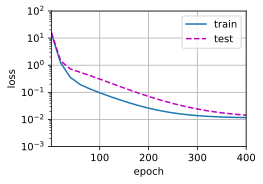

In [75]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.4630384 3.54057  ]]


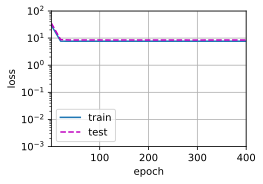

In [76]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9563584   1.2908328  -3.2704515   5.0692134  -0.38033572  1.25025
   0.36903235 -0.43950078  0.3408853  -0.05885685  0.13194074 -0.25906864
  -0.24294707 -0.4676497   0.3806056   0.03963903 -0.02340082  0.42762268
   0.01053774 -0.16390514]]


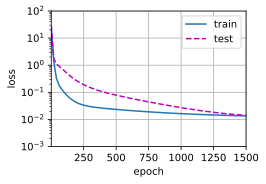

In [77]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)